https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [206]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from keras import backend as K
from tensorflow.keras.utils import plot_model
import random
from keras.regularizers import L2
import plotly.graph_objs as go
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [207]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')

In [208]:
# df.set_index('Date/Time', inplace = True)
print(df[df['provincename'] == 'Quebec'].index.min())
print(df[df['provincename'] == 'Quebec'].index.max())

0
79435


In [209]:
# convert date/time to date time format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# filter data to remove the rows that doesn't have productivity values
df = df[df['Date/Time'] <= '2021-12-31']

# set date/time as index
df.set_index('Date/Time', inplace = True)

# drop unnecessary columns
sectors_todrop = ['Manufacturing', 'Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']

df.drop(columns = sectors_todrop, inplace = True)

# convert 'GeoUID' to string
df['GeoUID'] = df['GeoUID'].astype('str')

# rename columns
df.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85601 entries, 1998-01-01 to 2017-12-01
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   provincename                       85601 non-null  object 
 1   Longitude                          85601 non-null  float64
 2   Latitude                           85601 non-null  float64
 3   Region.Name                        85601 non-null  object 
 4   Construction                       85601 non-null  float64
 5   Transportation and warehousing     85601 non-null  float64
 6   Health care and social assistance  85601 non-null  float64
 7   Agriculture                        85601 non-null  float64
 8   Wholesale trade Retail trade       85601 non-null  float64
 9   Population                         85601 non-null  float64
 10  GeoUID                             85601 non-null  object 
 11  Station Name                       85

## (1) Univariate ##

(1.1) Combination of all 5 provinces

In [211]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [212]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Transportation and warehousing
Date/Time                                 
1998-01-31                       52.522178
1998-02-28                       52.486863
1998-03-31                       52.422953
1998-04-30                       51.810442
1998-05-31                       51.795633


<Axes: title={'center': 'Transportation and warehousing'}, xlabel='Date/Time'>

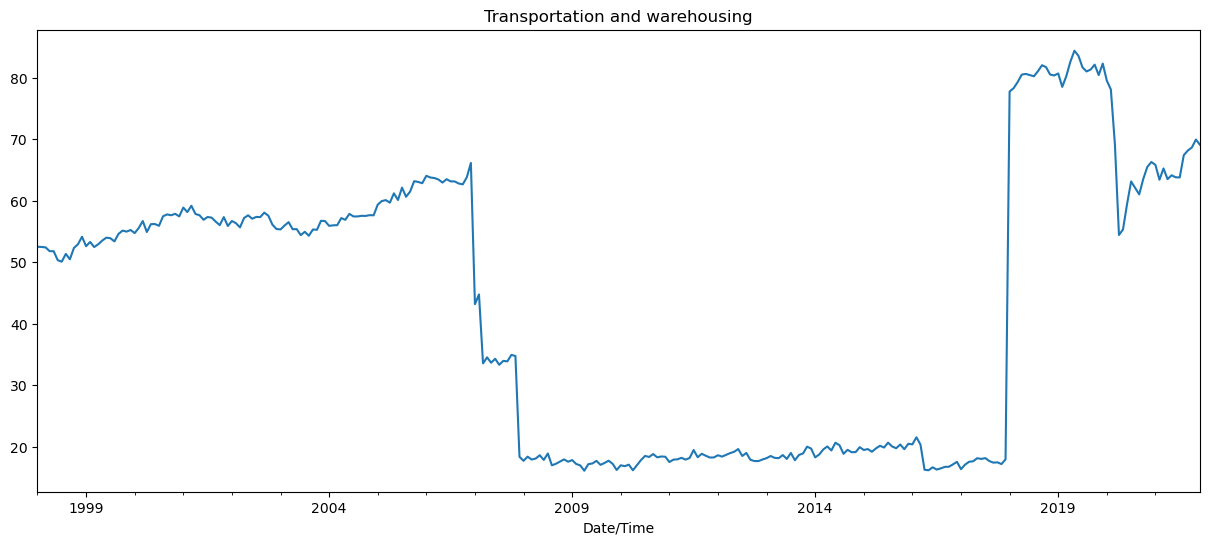

In [213]:
lstm_data = pd.DataFrame(resampled['Transportation and warehousing'])
print(lstm_data.head(5))
lstm_data['Transportation and warehousing'].plot(title = 'Transportation and warehousing')

In [214]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 93.94852447509766
R-squared from the last epoch: -81.43087005615234
Val Mean Squared Error (MSE) from the last epoch: 380.32354736328125
Val R-squared from the last epoch: -1.8573976755142212


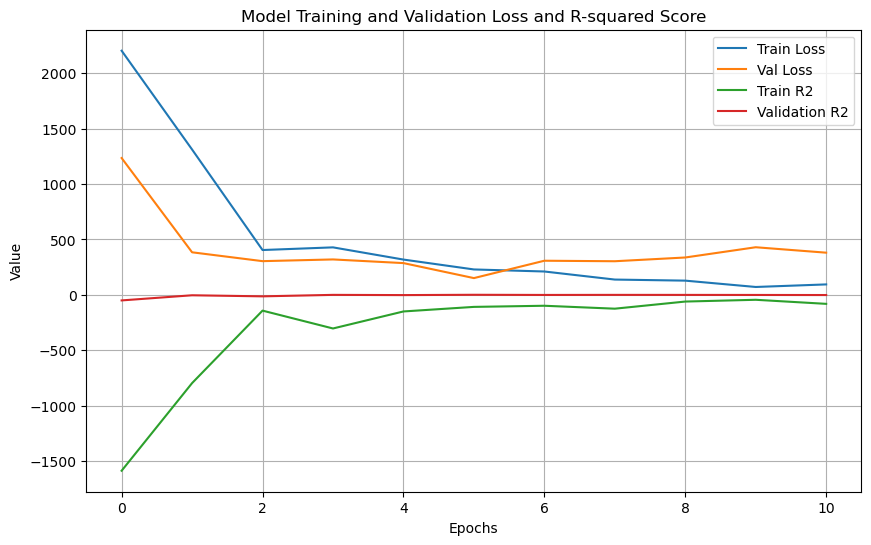

1/1 [==============================] - 0s 41ms/step - loss: 47.9583 - r_squared: 0.2289
MSE and R_squared: [47.958343505859375, 0.22886347770690918]
1/1 [==============================] - 1s 604ms/step
Predictions:
[77.55495, 77.79989, 77.55828, 77.13407, 76.22559, 76.806755, 76.005486, 75.38909, 71.2342, 64.223114]
Actual values:
[81.0201, 81.32521, 82.12788, 80.43968, 82.30499, 79.531248, 78.094261, 69.1529, 54.4338, 55.340437]


In [215]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True)))
model.add(Dropout(0.7))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))


def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model

from keras.optimizers import Adam

optimizer = Adam(learning_rate = 0.001, clipnorm=1.0)
model.compile(optimizer = optimizer, 
              loss = 'mse',
              metrics = [r_squared])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 100,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping],
          validation_split = 0.2,
          shuffle = False)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='LSTM Univariate Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.2) Alberta

In [216]:
resampled_AB = df[df['provincename'] == 'Alberta']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_AB.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [217]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Transportation and warehousing
Date/Time                                 
1998-01-31                       65.161046
1998-02-28                       65.419553
1998-03-31                       59.658920
1998-04-30                       60.083371
1998-05-31                       60.766897


<Axes: title={'center': 'Transportation and warehousing'}, xlabel='Date/Time'>

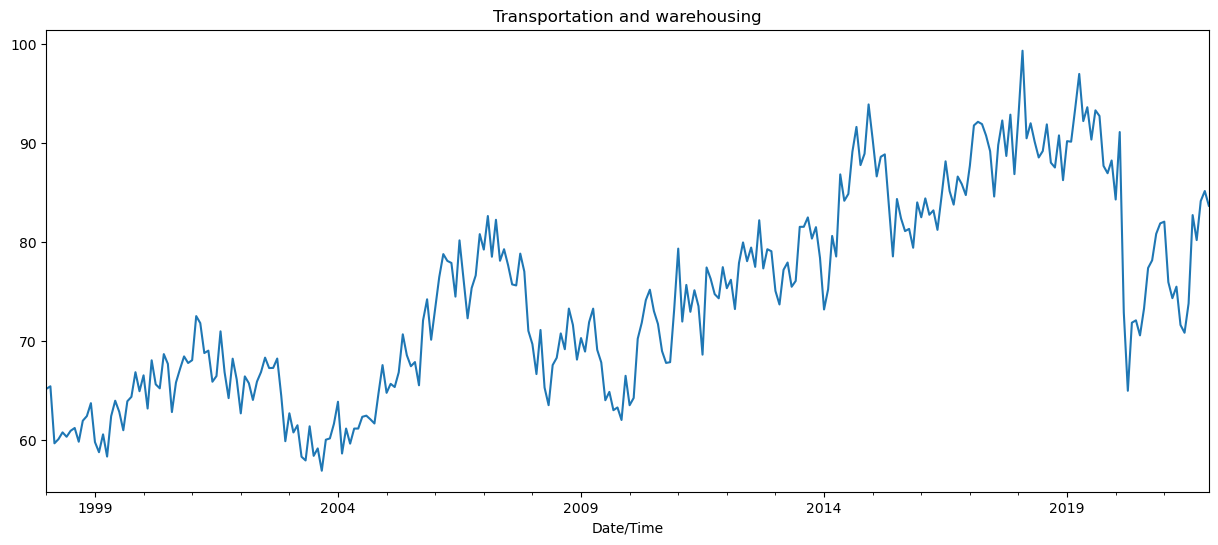

In [218]:
lstm_data = pd.DataFrame(resampled['Transportation and warehousing'])
print(lstm_data.head(5))
lstm_data['Transportation and warehousing'].plot(title = 'Transportation and warehousing')

In [219]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 9.161314010620117
R-squared from the last epoch: 0.8961144685745239


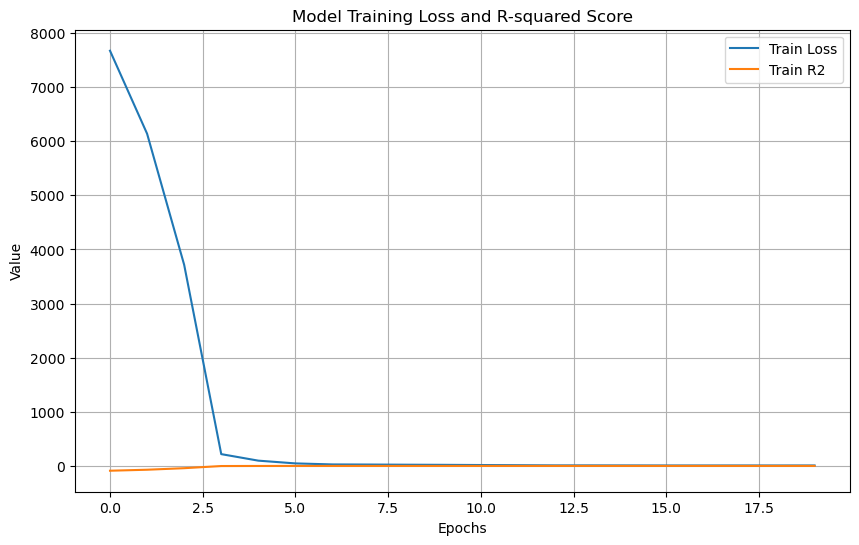

1/1 [==============================] - 0s 436ms/step - loss: 31.8590 - r_squared: 0.3983
MSE and R_squared: [31.859025955200195, 0.39827072620391846]
1/1 [==============================] - 0s 230ms/step
Predictions:
[89.095985, 91.96017, 92.34155, 88.93159, 87.98954, 87.722694, 85.09188, 91.957214, 80.031624, 75.22233]
Actual values:
[93.293103, 92.72245, 87.68206, 86.94018, 88.22906, 84.285608, 91.09958, 72.88339, 64.966194, 71.84203]


In [220]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Univariate Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.3) Bristish Columbia

In [221]:
resampled_BC = df[df['provincename'] == 'British Columbia']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_BC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [222]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Transportation and warehousing
Date/Time                                 
1998-01-31                       50.050869
1998-02-28                       49.415873
1998-03-31                       49.101908
1998-04-30                       47.480154
1998-05-31                       48.699568


<Axes: title={'center': 'Transportation and warehousing'}, xlabel='Date/Time'>

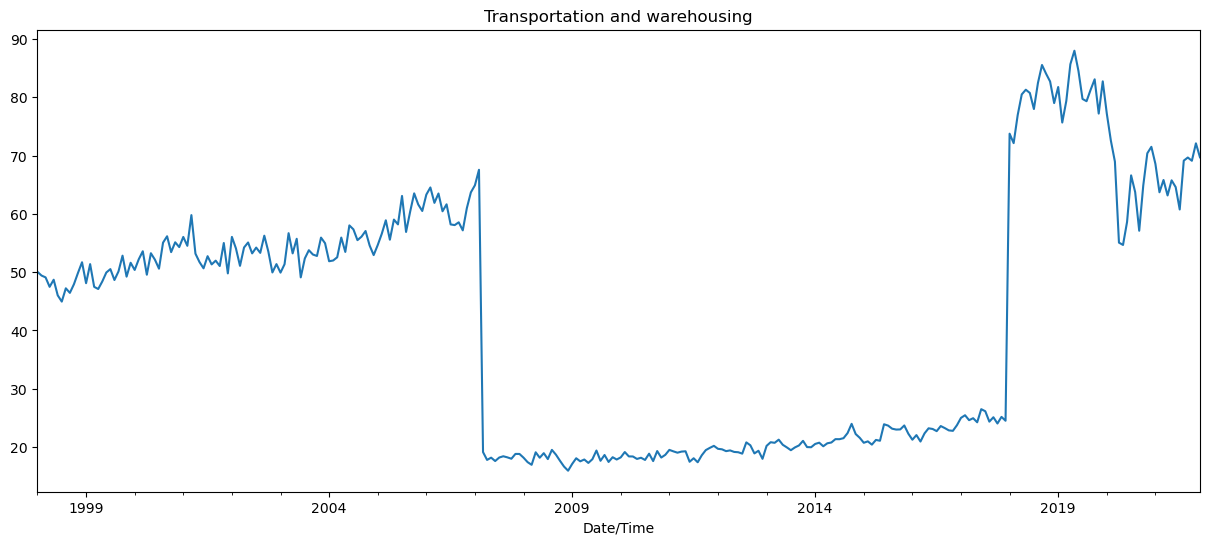

In [223]:
lstm_data = pd.DataFrame(resampled['Transportation and warehousing'])
print(lstm_data.head(5))
lstm_data['Transportation and warehousing'].plot(title = 'Transportation and warehousing')

In [224]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


In [225]:
# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Mean Squared Error (MSE) from the last epoch: 24.825237274169922
R-squared from the last epoch: 0.9374931454658508


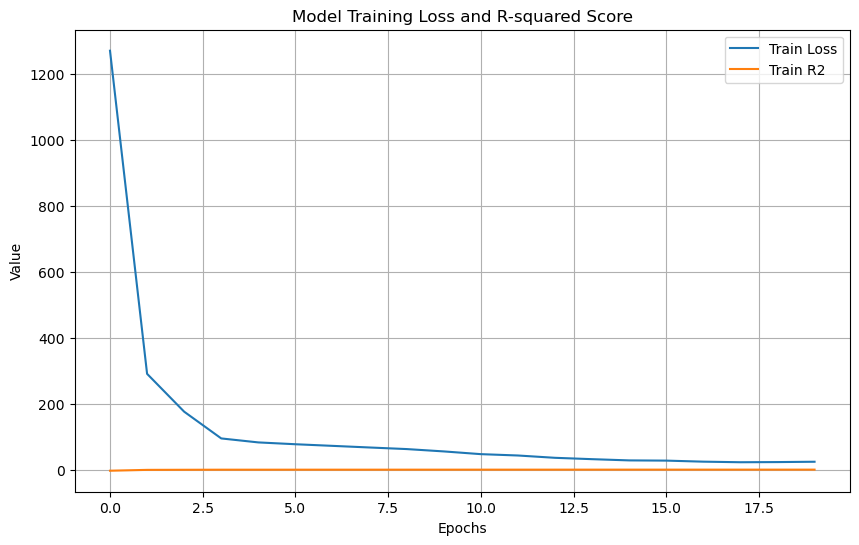

1/1 [==============================] - 0s 310ms/step - loss: 42.4731 - r_squared: 0.2641
MSE and R_squared: [42.473079681396484, 0.2640964388847351]
1/1 [==============================] - 0s 262ms/step
Predictions:
[83.041275, 82.32632, 83.34048, 84.2993, 82.125725, 81.76018, 81.30144, 78.003075, 76.00728, 65.04217]
Actual values:
[79.326798, 81.27875, 83.08465, 77.2052, 82.733674, 77.19451, 72.5711, 68.95961, 55.06325, 54.66684]


In [226]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Univariate Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.4) Ontario

In [227]:
resampled_ON = df[df['provincename'] == 'Ontario']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_ON.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [228]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Transportation and warehousing
Date/Time                                 
1998-01-31                      132.983116
1998-02-28                      132.027216
1998-03-31                      137.246137
1998-04-30                      137.479360
1998-05-31                      136.070638


<Axes: title={'center': 'Transportation and warehousing'}, xlabel='Date/Time'>

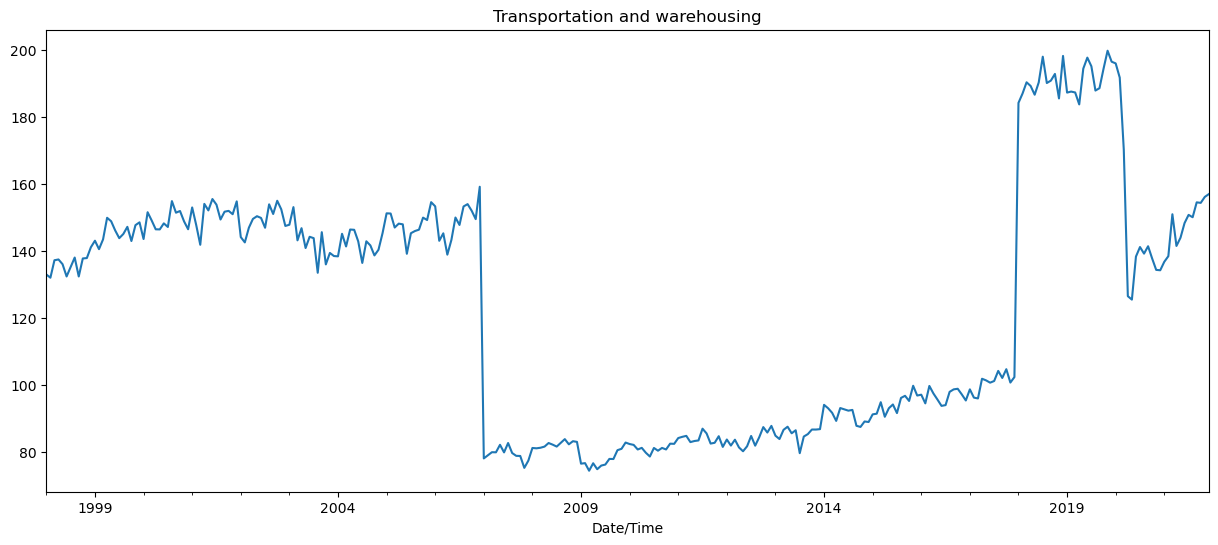

In [229]:
lstm_data = pd.DataFrame(resampled['Transportation and warehousing'])
print(lstm_data.head(5))
lstm_data['Transportation and warehousing'].plot(title = 'Transportation and warehousing')

In [230]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 97.80921936035156
R-squared from the last epoch: 0.9206370115280151


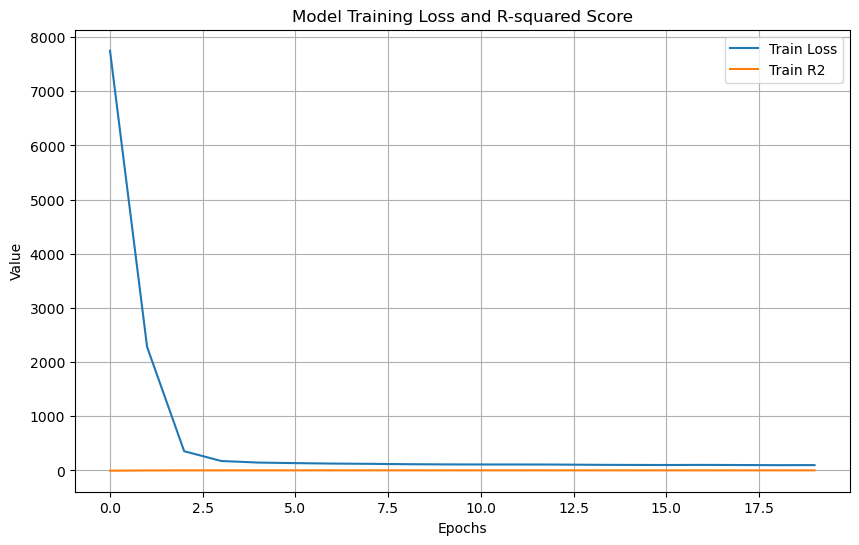

1/1 [==============================] - 0s 304ms/step - loss: 230.8451 - r_squared: 0.5685
MSE and R_squared: [230.84506225585938, 0.5684638023376465]
1/1 [==============================] - 0s 206ms/step
Predictions:
[193.93008, 193.73526, 192.17624, 191.38675, 194.13809, 196.60545, 197.25735, 196.29509, 190.4392, 114.886154]
Actual values:
[187.96317, 188.6636, 194.46754, 199.86207, 196.58168, 196.07558, 191.82807, 170.27614, 126.5074, 125.48141]


In [231]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Univariate Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.5) Quebec

In [232]:
resampled_QC = df[df['provincename'] == 'Quebec']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_QC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [233]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Transportation and warehousing
Date/Time                                 
1998-01-31                       26.979831
1998-02-28                       28.244141
1998-03-31                       29.007407
1998-04-30                       28.899912
1998-05-31                       27.370411


<Axes: title={'center': 'Transportation and warehousing'}, xlabel='Date/Time'>

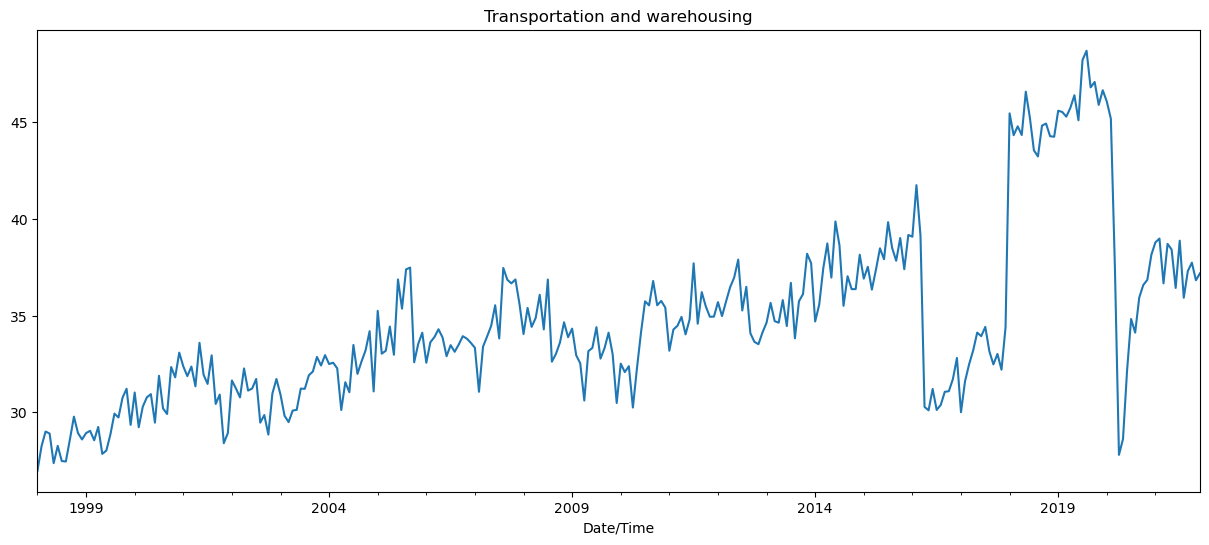

In [234]:
lstm_data = pd.DataFrame(resampled['Transportation and warehousing'])
print(lstm_data.head(5))
lstm_data['Transportation and warehousing'].plot(title = 'Transportation and warehousing')

In [235]:
# Initialize an empty dictionary to store DataFrames for each column
resampled_dataframes = {}

# Iterate over each column name
for column in columns:
    # Get the data for the current column
    column_data = resampled[column]
    
    # Convert to DataFrame and store in the dictionary
    column_data_df = pd.DataFrame(column_data)
    resampled_dataframes[column] = column_data_df
    
    # Display the first 14 rows
    print(f"Data for column '{column}':")
    print(column_data_df.head(3))

Data for column 'Construction':
            Construction
Date/Time               
1998-01-31     44.009793
1998-02-28     47.135313
1998-03-31     48.664697
Data for column 'Transportation and warehousing':
            Transportation and warehousing
Date/Time                                 
1998-01-31                       26.979831
1998-02-28                       28.244141
1998-03-31                       29.007407
Data for column 'Health care and social assistance':
            Health care and social assistance
Date/Time                                    
1998-01-31                          76.390411
1998-02-28                          78.896252
1998-03-31                          79.649614
Data for column 'Agriculture':
            Agriculture
Date/Time              
1998-01-31    26.874227
1998-02-28    26.326112
1998-03-31    26.940388
Data for column 'Wholesale trade Retail trade':
            Wholesale trade Retail trade
Date/Time                               
1998-01-31    

In [236]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

In [237]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 2.872901439666748
R-squared from the last epoch: 0.7708349227905273


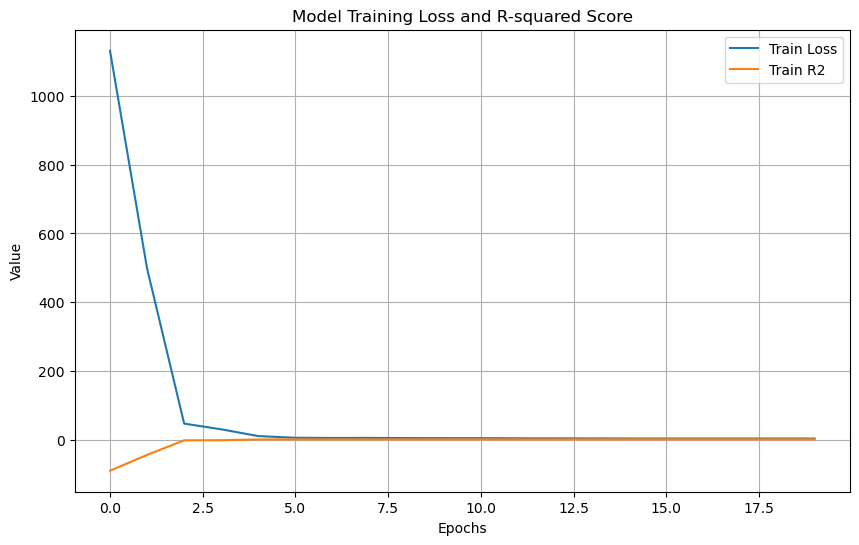

1/1 [==============================] - 0s 365ms/step - loss: 9.4591 - r_squared: 0.6526
MSE and R_squared: [9.459115982055664, 0.652603030204773]
1/1 [==============================] - 0s 290ms/step
Predictions:
[47.803528, 48.477352, 47.726112, 47.79058, 46.805946, 47.011898, 46.333885, 45.676758, 38.417248, 27.783524]
Actual values:
[48.700624, 46.804096, 47.084904, 45.89845, 46.656702, 46.072642, 45.18223, 37.478148, 27.801647, 28.624302]


In [238]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Quebec: LSTM Univariate Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

(1.6) Saskatchewan

In [239]:
resampled_SK = df[df['provincename'] == 'Saskatchewan']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_SK.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [240]:
# define a function that will split the sequence into desired number of steps
def split_sequence(df, n_features):
    data = df.values
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_features
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

columns = ['Construction', 
            'Transportation and warehousing', 
            'Health care and social assistance', 
            'Agriculture', 
            'Wholesale trade Retail trade', 
            'Mean Max Temp (°C)', 
            'Mean Min Temp (°C)', 
            'Mean Temp (°C)', 
            'Extr Max Temp (°C)', 
            'Extr Min Temp (°C)', 
            'Total Rain (mm)', 
            'Total Snow (cm)', 
            'Total Precip (mm)', 
            'Snow Grnd Last Day (cm)', 
            'Dir of Max Gust (10s deg)', 
            'Spd of Max Gust (km/h)']

            Transportation and warehousing
Date/Time                                 
1998-01-31                        1.662302
1998-02-28                        1.621951
1998-03-31                        1.577947
1998-04-30                        1.698861
1998-05-31                        1.719016


<Axes: title={'center': 'Transportation and warehousing'}, xlabel='Date/Time'>

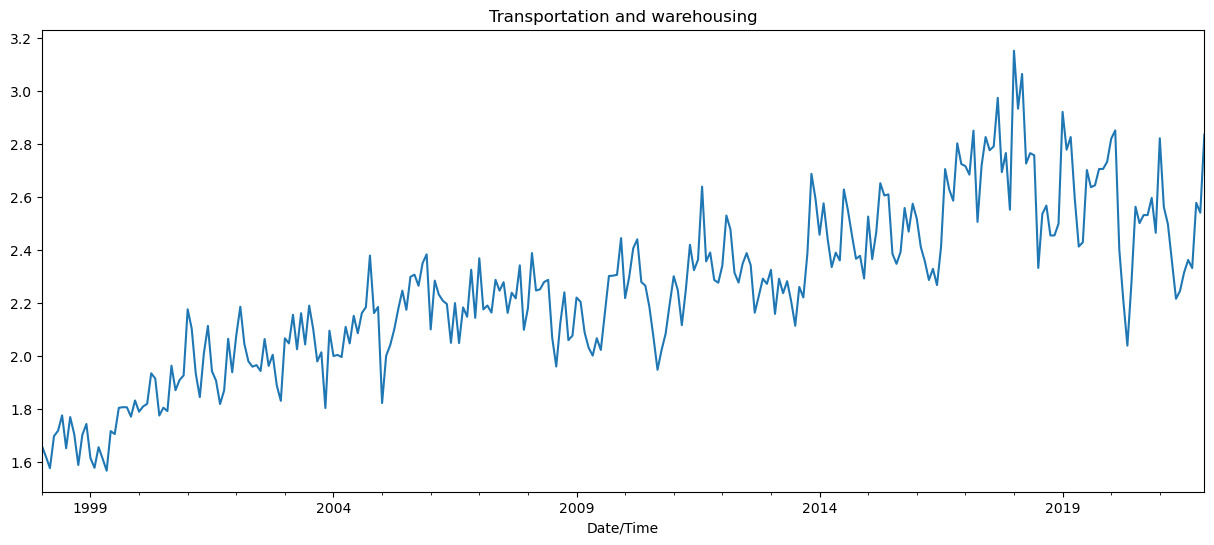

In [241]:
lstm_data = pd.DataFrame(resampled['Transportation and warehousing'])
print(lstm_data.head(5))
lstm_data['Transportation and warehousing'].plot(title = 'Transportation and warehousing')

In [242]:
# split into train and test
train_end_date = '2018-12-31'

train_data = lstm_data[lstm_data.index <= train_end_date]
test_data = lstm_data[lstm_data.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())

# TRAIN DATA #

# number of time steps
n_steps = 7

# split into samples | will have features and target variables
X_train, y_train = split_sequence(train_data, n_steps)

# for i in range(len(X_train)):
#  print(X_train[i], y_train[i])
 
 # TEST DATA #

# split into samples | will have features and target variables
X_test, y_test = split_sequence(test_data, n_steps)

# for i in range(len(X_test)):
#  print(X_test[i], y_test[i])

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00


LSTM Model Development

Mean Squared Error (MSE) from the last epoch: 0.028027357533574104
R-squared from the last epoch: 0.6102393865585327


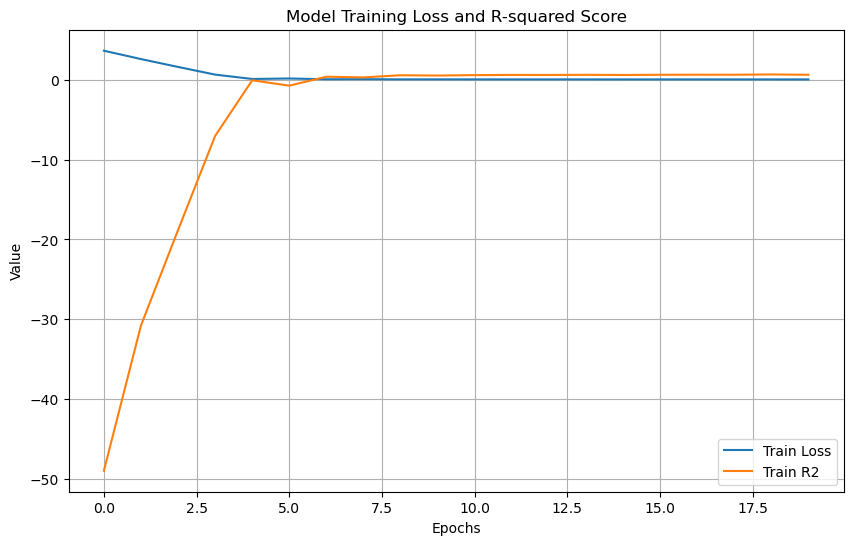

1/1 [==============================] - 0s 319ms/step - loss: 0.0749 - r_squared: -0.7457
MSE and R_squared: [0.0749317929148674, -0.7457472085952759]
1/1 [==============================] - 0s 273ms/step
Predictions:
[2.7701724, 2.7157288, 2.6914408, 2.6776, 2.706675, 2.7681894, 2.8379164, 2.8711967, 2.8431807, 2.7578568]
Actual values:
[2.636994, 2.6442411, 2.7055885, 2.706, 2.73271, 2.8197408, 2.8511399, 2.402912, 2.2094492, 2.0397682]


In [243]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features), kernel_regularizer=L2(0.001), return_sequences=True))
# model.add(LSTM(50, activation='relu', kernel_regularizer=L2(0.01)))
# model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
model.compile(optimizer='adam', 
              loss='mse',
              metrics=[r_squared])

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, 
          epochs = 20,
          batch_size = 32,
          verbose = 0,
          callbacks=[early_stopping])

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]

# Print the MSE and R-squared
print("Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("R-squared from the last epoch:", last_epoch_r_squared)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')

plt.title('Model Training Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("MSE and R_squared:", loss)

# make prediction on test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
y_pred = model.predict(X_test)

# Print the first 5 predictions and actual values
print("Predictions:")
flattened_predictions = [pred[0] for pred in y_pred[:10]]
print(flattened_predictions)
# print(y_pred[:10].tolist())
print("Actual values:")
rounded_actual_values = [round(value, len(str(prediction).split('.')[1])) for value, prediction in zip(y_test[:10], flattened_predictions)]
print(rounded_actual_values)

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual')
trace2 = go.Scatter(x=np.arange(len(y_pred)), y=y_pred.flatten(), mode='lines', name='Predicted')

# Create layout
layout = go.Layout(
    title='Saskatchewan: LSTM Univariate Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

## (2) Multivariate ##

In [244]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15, 6)
mpl.rcParams['axes.grid'] = False

In [245]:
columns = [
    'Transportation and warehousing',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)'
]

(2.1) Combination of all 5 provinces

In [246]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [247]:
resampled = resampled[columns]
resampled.head()


,Transportation and warehousing,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,52.522178,-3.476795,-11.475936,-7.483320,7.229147,-25.824194,62.171390,30.895640,102.139782,16.223433,0.498638,1.321526
1998-02-28,52.486863,2.335362,-6.219163,-1.968022,8.785487,-16.149888,43.465123,9.188011,57.897275,14.411444,0.370572,1.049046
1998-03-31,52.422953,4.270940,-5.059074,-0.388330,15.420638,-16.974551,43.057493,17.122616,65.206267,5.264305,0.326975,1.237057
1998-04-30,51.810442,12.866301,0.774230,6.834755,23.147497,-4.935786,34.318699,2.743902,39.689702,0.143631,0.382114,1.281843
1998-05-31,51.795633,19.732610,6.950949,13.355348,27.606341,0.251378,48.026216,0.022973,53.502432,0.000000,0.491892,1.432432


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

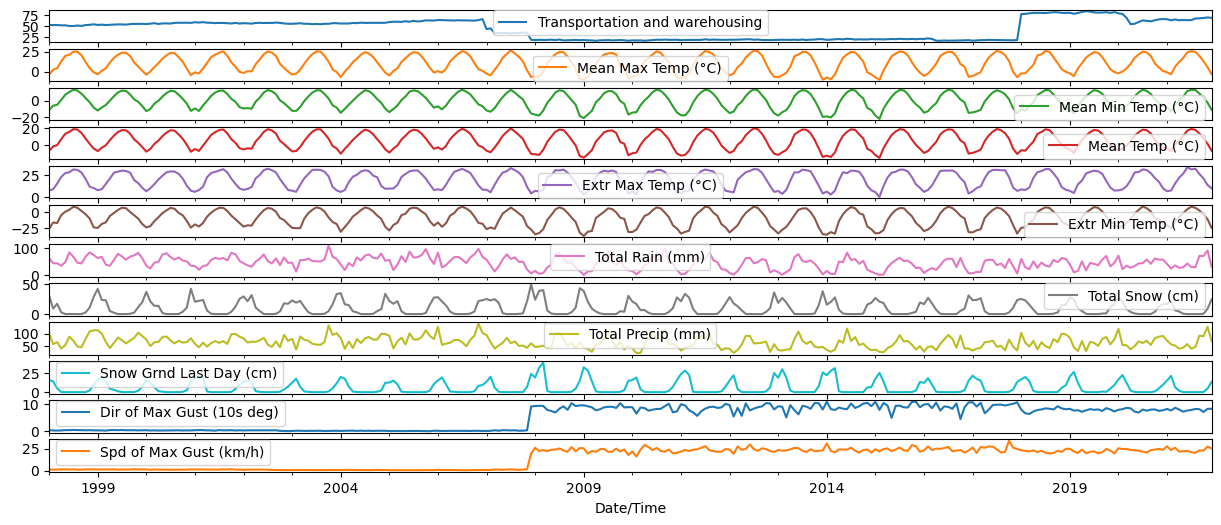

In [248]:
resampled[[
    'Transportation and warehousing',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [249]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 12)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 12)


In [250]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 52.522178   -3.4767949 -11.4759355  -7.4833201   7.2291474 -25.8241937
  62.1713896  30.8956403 102.139782   16.2234332   0.4986376   1.3215259]
(252, 12)
[ 80.6948052  -2.1700278 -11.0185331  -5.7069306   6.8378669 -21.5959822
  39.3739899  27.5800505  83.7204545  21.0075758   8.3459596  24.7828283]
(36, 12)


In [251]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i-n_past,0])
    return np.array(dataX),np.array(dataY)    

In [252]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 11)
y_train: (251,)
After reshape:
X_train: (251, 11)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 11)
y_test: (35,)
After reshape:
X_test: (35, 11)
y_test: (35, 1)


In [253]:
train_data_array[0]

array([ 52.522178 ,  -3.4767949, -11.4759355,  -7.4833201,   7.2291474,
       -25.8241937,  62.1713896,  30.8956403, 102.139782 ,  16.2234332,
         0.4986376,   1.3215259])

In [254]:
X_train[0]

array([ -3.4767949, -11.4759355,  -7.4833201,   7.2291474, -25.8241937,
        62.1713896,  30.8956403, 102.139782 ,  16.2234332,   0.4986376,
         1.3215259])

In [255]:
y_train[0]

array([52.522178])

In [256]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.2717263 -1.1356841 -1.212685  -1.3017714 -1.2612386  0.7435674
  1.77102    1.6211229  1.1663778 -0.987954  -1.0044652]
X_train_scaled: (251, 11)
y_train_scaled: [[0.678025 ]
 [0.6763198]
 [0.673234 ]
 [0.6436593]
 [0.6429443]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.4028358 -1.4341236 -1.3481355 -1.4347778 -1.3054004 -0.1787639
  2.2894488  0.8274613  1.925502   0.9571737  0.9932593]
X_test_scaled: (35, 11)
y_test_scaled: [[1.0890218]
 [0.8472073]
 [1.0409659]
 [1.299885 ]
 [1.4988652]]
y_test_scaled: (35, 1)


In [257]:
y_train_scaled

array([[ 0.678025 ],
       [ 0.6763198],
       [ 0.673234 ],
       [ 0.6436593],
       [ 0.6429443],
       [ 0.5727247],
       [ 0.5613624],
       [ 0.6220541],
       [ 0.579647 ],
       [ 0.6685525],
       [ 0.6976657],
       [ 0.756781 ],
       [ 0.6822036],
       [ 0.7159286],
       [ 0.6757002],
       [ 0.697518 ],
       [ 0.72687  ],
       [ 0.7493586],
       [ 0.7450306],
       [ 0.7200461],
       [ 0.7786084],
       [ 0.8048504],
       [ 0.7970559],
       [ 0.8094597],
       [ 0.7851981],
       [ 0.8254667],
       [ 0.8799191],
       [ 0.7936141],
       [ 0.8553693],
       [ 0.8564377],
       [ 0.8423756],
       [ 0.9169749],
       [ 0.9320033],
       [ 0.9251669],
       [ 0.9366853],
       [ 0.9162442],
       [ 0.9854847],
       [ 0.9503402],
       [ 0.9998136],
       [ 0.9355005],
       [ 0.9253693],
       [ 0.8897139],
       [ 0.9116924],
       [ 0.9064785],
       [ 0.8753183],
       [ 0.8478961],
       [ 0.910892 ],
       [ 0.84

In [258]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 11)
X_test: (35, 11)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_17 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_42 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

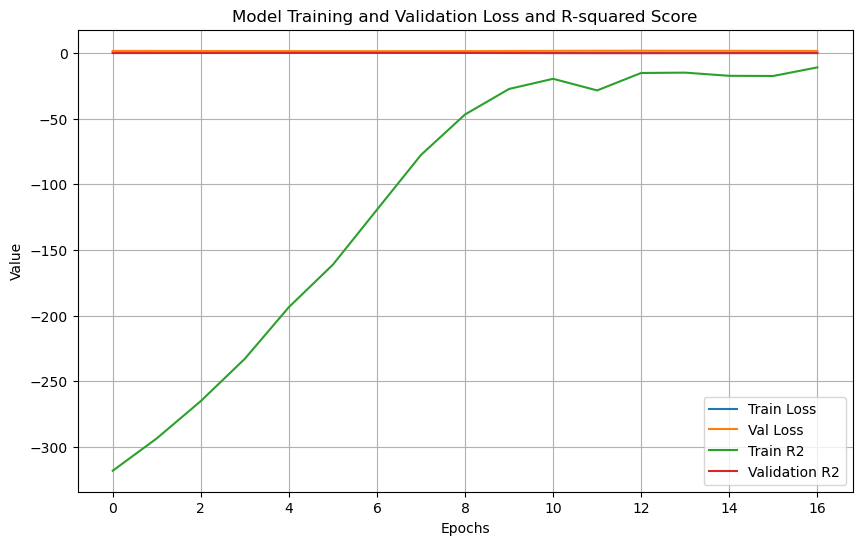

In [259]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.2)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [260]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 9ms/step - loss: 1.2149 - r_squared: -39.5259
MSE and R_squared: [1.2148650884628296, -39.52588653564453]


In [261]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 0s/step
train_predict: (251, 1)
test_predict: (35, 1)


In [262]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)


In [263]:
train_predict[0:10]

array([[55.829216],
       [54.670757],
       [53.808685],
       [53.108273],
       [53.9227  ],
       [55.571453],
       [54.519115],
       [54.080223],
       [53.90259 ],
       [56.087517]], dtype=float32)

In [264]:
print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

Train Mean Absolute Error: 6.055499846108115
Train Root Mean Squared Error: 12.884084305026004


In [265]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)


In [266]:
print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

Test Mean Absolute Error: 8.8034481845135
Test Root Mean Squared Error: 9.94272778531688


(2.2) Alberta

In [267]:
resampled_AB = df[df['provincename'] == 'Alberta']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_AB.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()


,Transportation and warehousing,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,65.161046,-9.174123,-19.446359,-14.327202,7.285181,-36.542816,0.085185,16.261111,15.305556,7.611111,1.388889,2.129630
1998-02-28,65.419553,1.726643,-9.481329,-3.892085,9.294639,-18.085026,0.059259,2.807407,2.512963,6.018519,0.240741,0.685185
1998-03-31,59.658920,2.130065,-9.171270,-3.530172,13.286094,-24.753519,1.240741,23.177778,21.712963,2.666667,0.907407,2.814815
1998-04-30,60.083371,13.155375,-0.826884,6.184374,22.869606,-6.995261,14.363636,5.376364,20.041818,0.000000,0.563636,3.236364
1998-05-31,60.766897,20.054474,4.686848,12.396424,27.039213,-1.883615,48.781818,0.000000,49.996364,0.000000,1.636364,4.363636


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

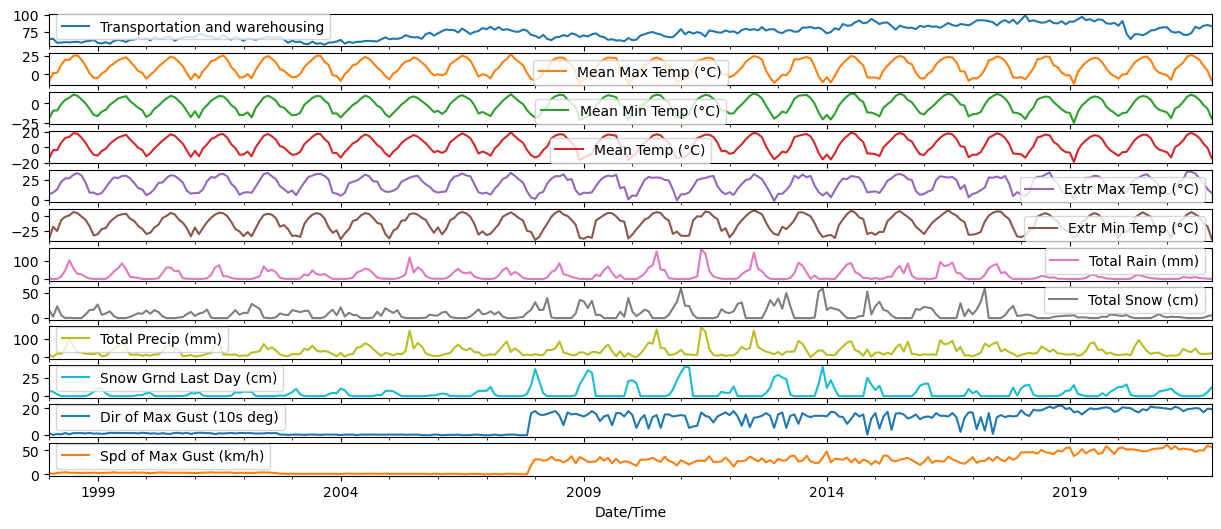

In [268]:
resampled[[
    'Transportation and warehousing',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [269]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 12)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 12)


In [270]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 65.1610458  -9.1741231 -19.4463592 -14.3272019   7.285181  -36.5428164
   0.0851852  16.2611111  15.3055556   7.6111111   1.3888889   2.1296296]
(252, 12)
[ 90.1814401  -1.4695154 -12.5759629  -7.0314582   9.4384384 -25.7321695
   0.2216667   4.7733333  15.1466667   7.8        20.3166667  56.1333333]
(36, 12)


In [271]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i - n_past,0])
    return np.array(dataX),np.array(dataY)    

In [272]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 11)
y_train: (251,)
After reshape:
X_train: (251, 11)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 11)
y_test: (35,)
After reshape:
X_test: (35, 11)
y_test: (35, 1)


In [273]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.6739582 -1.7514795 -1.7150953 -1.2999966 -1.7867056 -0.7700451
  0.5765474 -0.6783407  0.3928021 -0.8713735 -0.9757997]
X_train_scaled: (251, 11)
y_train_scaled: [[-0.8358031]
 [-0.8091916]
 [-1.4022085]
 [-1.3585142]
 [-1.28815  ]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.0923552 -1.051098  -1.0760606 -1.1462961 -0.9786206 -0.8188307
  1.0999696 -0.6778062  0.7844273  0.6892207  0.912444 ]
X_test_scaled: (35, 11)
y_test_scaled: [[0.9643134]
 [0.9578186]
 [1.3528443]
 [1.767639 ]
 [1.203849 ]]
y_test_scaled: (35, 1)


In [274]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 11)
X_test: (35, 11)


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_19 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_44 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

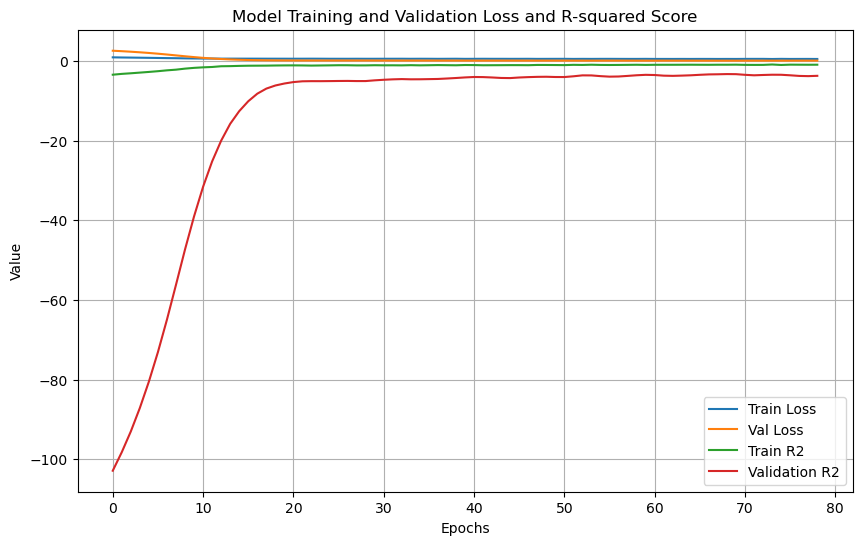

In [275]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.02)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [276]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 0s/step - loss: 1.6577 - r_squared: -3.8754
MSE and R_squared: [1.657671332359314, -3.8754491806030273]


In [277]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 3ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [278]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)
Train Mean Absolute Error: 5.692898861047703
Train Root Mean Squared Error: 7.031742588658703


In [279]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Alberta: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)
Test Mean Absolute Error: 9.437789979461812
Test Root Mean Squared Error: 10.87893750308521


(2.3) Bristish Columbia

In [280]:
resampled_BC = df[df['provincename'] == 'British Columbia']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_BC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Transportation and warehousing,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,50.050869,1.668112,-4.154257,-1.238191,9.430297,-17.129487,136.186364,33.692424,191.862121,11.113636,0.234848,1.409091
1998-02-28,49.415873,5.952033,-0.389383,2.724369,10.398405,-6.490740,100.753030,9.244697,122.815152,12.719697,0.234848,1.431818
1998-03-31,49.101908,8.189304,0.355152,4.292350,14.542492,-6.209205,70.272727,7.814394,90.611364,7.219697,0.234848,0.969697
1998-04-30,47.480154,13.038331,2.417762,7.737061,23.675751,-2.323696,45.203030,2.137879,53.328788,0.075758,0.234848,0.954545
1998-05-31,48.699568,18.087071,7.296346,12.687342,26.394613,2.266207,50.971429,0.001504,63.715038,0.000000,0.210526,0.759398


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

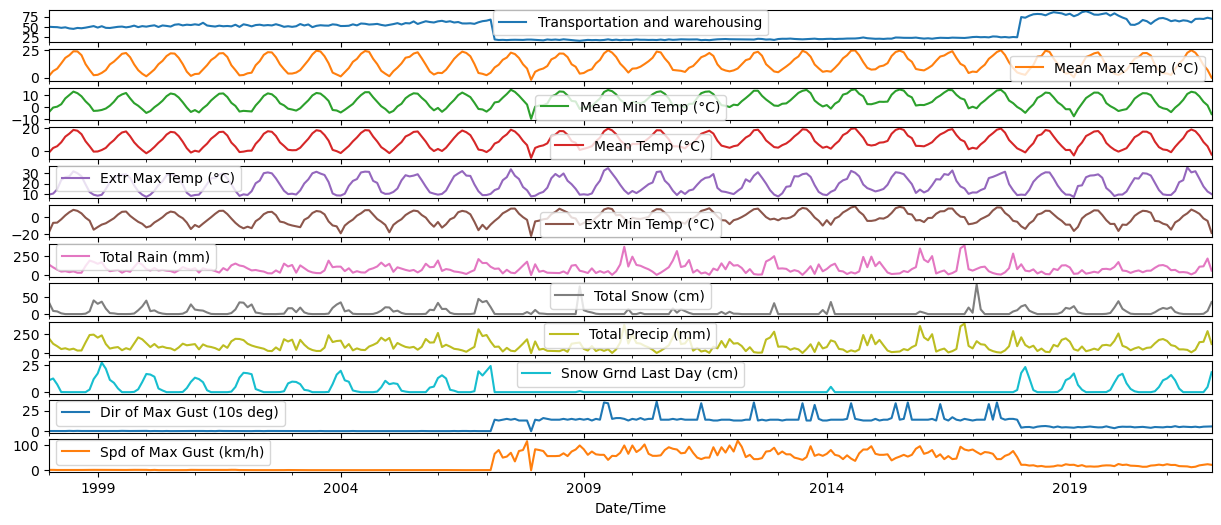

In [281]:
resampled[[
    'Transportation and warehousing',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [282]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 12)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 12)


In [283]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 50.0508693   1.6681116  -4.1542568  -1.2381905   9.430297  -17.1294871
 136.1863636  33.6924242 191.8621212  11.1136364   0.2348485   1.4090909]
(252, 12)
[ 81.7640539   4.0382238  -1.8094733   1.019516    9.3036543  -8.5928909
  99.6887324  15.6619718 150.7197183  13.0985915   4.5704225  21.0704225]
(36, 12)


In [284]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)    

In [285]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 11)
y_train: (251,)
After reshape:
X_train: (251, 11)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 11)
y_test: (35,)
After reshape:
X_test: (35, 11)
y_test: (35, 1)


In [286]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.616995  -1.6945536 -1.6619085 -1.280397  -2.403604   0.7666487
  2.3204026  1.2486119  1.5048966 -0.9337452 -0.9838437]
X_train_scaled: (251, 11)
y_train_scaled: [[0.5984102]
 [0.5821672]
 [0.4982658]
 [0.5613522]
 [0.4226977]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.1785048 -1.042412  -1.1325706 -1.2401377 -0.9162422  0.6779955
  1.0373571  0.8602578  1.4551158 -0.9715278  0.8358992]
X_test_scaled: (35, 11)
y_test_scaled: [[0.5477181]
 [0.9688242]
 [1.6848498]
 [1.9485932]
 [1.5537772]]
y_test_scaled: (35, 1)


In [287]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 11)
X_test: (35, 11)


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_21 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_46 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

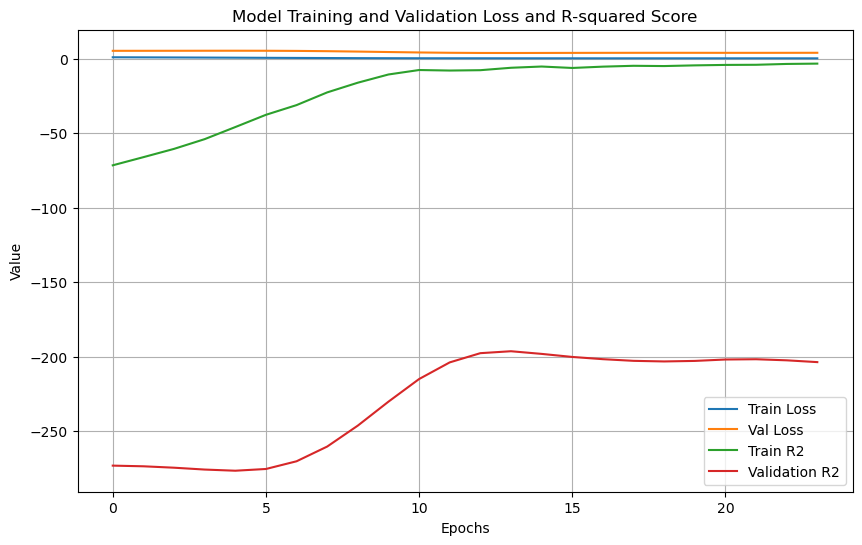

In [288]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.02)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [289]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 0s/step - loss: 1.1201 - r_squared: -12.5871
MSE and R_squared: [1.120133638381958, -12.587051391601562]


In [290]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 2ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [291]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)
Train Mean Absolute Error: 5.502342317643044
Train Root Mean Squared Error: 9.527608278094236


In [292]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='British Columbia: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)
Test Mean Absolute Error: 7.8586495367204225
Test Root Mean Squared Error: 9.306693185615206


(2.4) Ontario

In [293]:
resampled_ON = df[df['provincename'] == 'Ontario']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_ON.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Transportation and warehousing,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,132.983116,-1.335346,-8.817714,-5.073900,8.603917,-21.208080,51.952941,32.298039,90.741176,12.921569,0.450980,1.098039
1998-02-28,132.027216,2.038014,-6.539054,-2.244561,8.939422,-17.776302,25.582353,4.156863,31.288235,4.627451,0.607843,1.019608
1998-03-31,137.246137,4.565397,-4.241625,0.163845,21.541639,-17.859510,49.825490,25.756863,77.333333,0.843137,0.078431,1.156863
1998-04-30,137.479360,13.340110,1.406302,7.379227,21.728006,-4.285085,39.958824,0.517647,42.747059,0.000000,0.411765,1.019608
1998-05-31,136.070638,21.705825,9.513872,15.624558,29.795932,2.421586,42.966667,0.031373,47.249020,0.000000,0.470588,1.352941


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

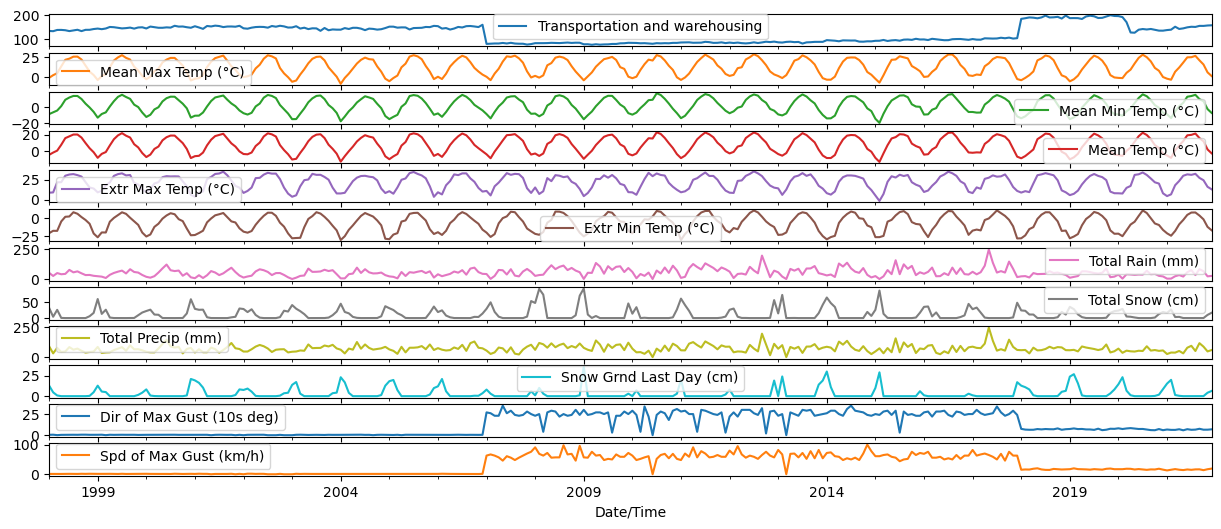

In [294]:
resampled[[
    'Transportation and warehousing',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [295]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 12)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 12)


In [296]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[132.9831158  -1.335346   -8.8177137  -5.0739      8.6039171 -21.2080801
  51.9529412  32.2980392  90.7411765  12.9215686   0.4509804   1.0980392]
(252, 12)
[187.3492669  -5.8150245 -15.2330949 -10.6046854   5.542479  -28.5820362
  10.7        35.25       57.4672414  23.7931034   7.3448276  17.1034483]
(36, 12)


In [297]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i- n_past,0])
    return np.array(dataX),np.array(dataY)    

In [298]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 11)
y_train: (251,)
After reshape:
X_train: (251, 11)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 11)
y_test: (35,)
After reshape:
X_test: (35, 11)
y_test: (35, 1)


In [299]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.3306549 -1.1692373 -1.2550456 -1.4131459 -1.2103616 -0.1511058
  1.1401111  0.5530732  1.6674448 -1.0146913 -1.0405387]
X_train_scaled: (251, 11)
y_train_scaled: [[0.4854998]
 [0.4568582]
 [0.6132324]
 [0.6202205]
 [0.578011 ]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.6693199 -1.7824638 -1.7333137 -1.5735091 -1.7535768 -1.2725134
  2.6237543 -0.159955   2.350585   0.5191867  0.3714311]
X_test_scaled: (35, 11)
y_test_scaled: [[0.9651793]
 [0.9772375]
 [0.9665787]
 [0.8252684]
 [1.248729 ]]
y_test_scaled: (35, 1)


In [300]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 11)
X_test: (35, 11)


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_23 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_48 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

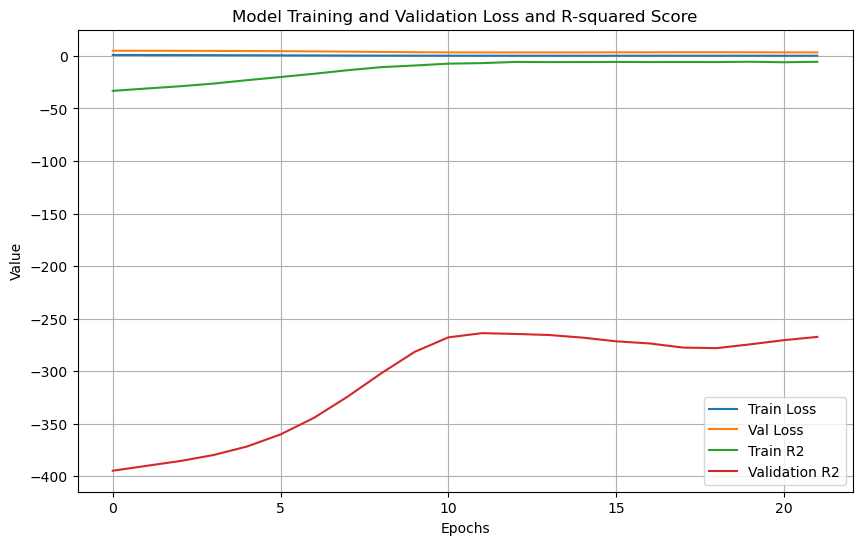

In [301]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.02)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [302]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 8ms/step - loss: 1.9734 - r_squared: -376.0245
MSE and R_squared: [1.9734017848968506, -376.02447509765625]


In [303]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 8ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [304]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)
Train Mean Absolute Error: 9.479637195973693
Train Root Mean Squared Error: 15.789811423259883


In [305]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Ontario: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)
Test Mean Absolute Error: 31.26068969295387
Test Root Mean Squared Error: 35.47577829203351


(2.5) Quebec

In [306]:
resampled_QC = df[df['provincename'] == 'Quebec']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_QC.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Transportation and warehousing,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,26.979831,-4.552563,-13.994682,-9.287824,5.741158,-29.829489,25.681176,43.316471,69.741176,35.976471,0.364706,0.847059
1998-02-28,28.244141,-0.896600,-11.473360,-6.188613,7.167492,-25.858277,14.797647,16.928235,32.250588,31.517647,0.329412,0.670588
1998-03-31,29.007407,2.044358,-7.643261,-2.797791,15.422714,-22.235325,45.856471,28.203529,75.307059,7.600000,0.341176,0.694118
1998-04-30,28.899912,11.654923,-0.400211,5.643657,22.055794,-6.318341,38.970588,4.340000,43.837647,0.505882,0.317647,0.658824
1998-05-31,27.370411,20.997578,7.887234,14.470646,28.402177,-0.216450,57.038824,0.000000,57.442353,0.000000,0.105882,0.717647


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

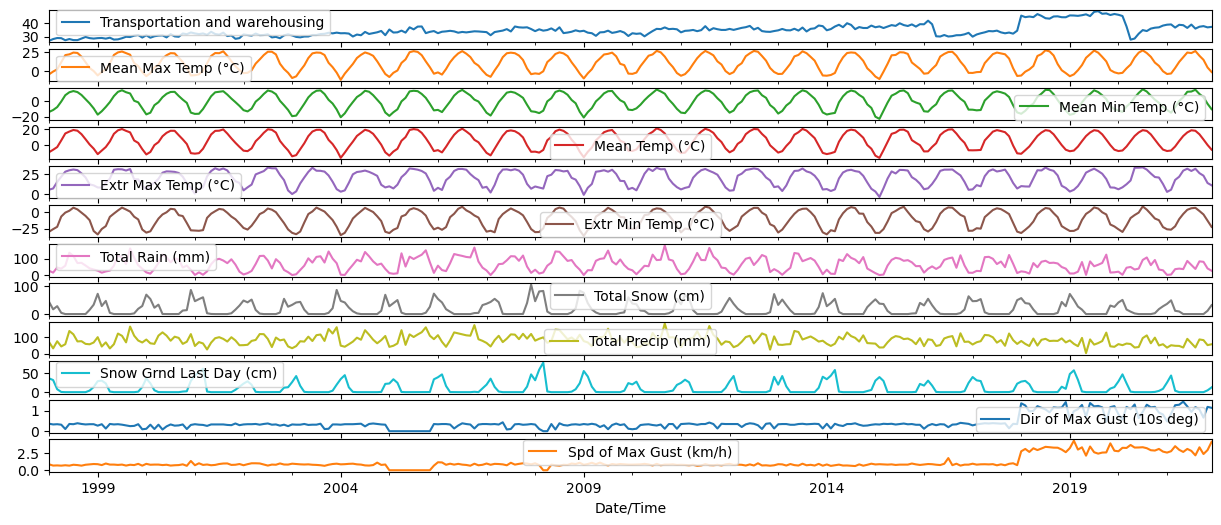

In [307]:
resampled[[
    'Transportation and warehousing',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [308]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 12)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 12)


In [309]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[ 26.979831   -4.5525631 -13.9946817  -9.2878244   5.7411585 -29.8294891
  25.6811765  43.3164706  69.7411765  35.9764706   0.3647059   0.8470588]
(252, 12)
[ 45.5983577  -7.0949903 -17.6618325  -8.0750908   3.3135323 -28.7134663
   9.2883721  71.6697674  80.3651163  47.3023256   0.5465116   3.1744186]
(36, 12)


In [310]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i- n_past,0])
    return np.array(dataX),np.array(dataY)    

In [311]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 11)
y_train: (251,)
After reshape:
X_train: (251, 11)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 11)
y_test: (35,)
After reshape:
X_test: (35, 11)
y_test: (35, 1)


In [312]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.3560138 -1.3498707 -1.3662137 -1.4678788 -1.4961755 -0.9880388
  1.0566362 -0.5327677  1.6995575  0.1971918 -0.0546292]
X_train_scaled: (251, 11)
y_train_scaled: [[-1.8691995]
 [-1.5231536]
 [-1.3142451]
 [-1.3436671]
 [-1.7622964]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.6756263 -1.8152368 -1.4598729 -1.7031133 -1.5446269 -1.1677441
  3.0049003  0.720013   2.2754468 -1.7808884  0.4535785]
X_test_scaled: (35, 11)
y_test_scaled: [[0.9744424]
 [0.9625959]
 [0.91944  ]
 [1.0007273]
 [1.1177068]]
y_test_scaled: (35, 1)


In [313]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 11)
X_test: (35, 11)


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_25 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_50 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

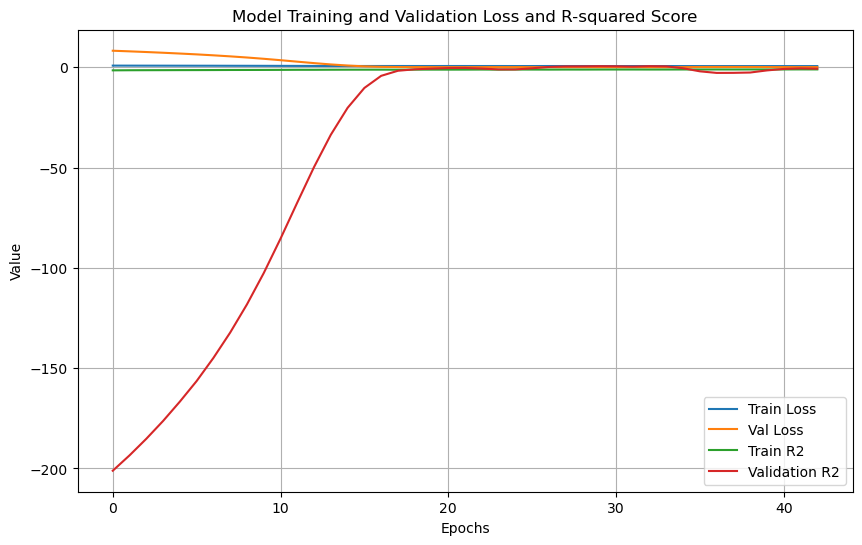

In [314]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.02)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [315]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 6ms/step - loss: 1.0736 - r_squared: -34.3000
MSE and R_squared: [1.0735501050949097, -34.299957275390625]


In [316]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 8ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [317]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Quebec: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)
Train Mean Absolute Error: 2.2215229704311223
Train Root Mean Squared Error: 2.7729780883367354


In [318]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Quebec: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)
Test Mean Absolute Error: 4.800076683753166
Test Root Mean Squared Error: 5.7856965888219065


(2.6) Saskatchewan

In [319]:
resampled_SK = df[df['provincename'] == 'Saskatchewan']

# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = resampled_SK.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

resampled = resampled[columns]
resampled.head()

,Transportation and warehousing,Mean Max Temp (°C),Mean Min Temp (°C),Mean Temp (°C),Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h)
Date/Time,,,,,,,,,,,,
1998-01-31,1.662302,-12.126696,-21.643371,-16.911877,1.957775,-36.132356,0.071111,15.202222,17.271111,7.977778,0.511111,1.244444
1998-02-28,1.621951,-1.101262,-9.118113,-5.137857,6.325029,-21.979885,1.924444,7.760000,12.533333,8.222222,0.733333,1.111111
1998-03-31,1.577947,-0.781830,-12.051365,-6.422710,13.616929,-28.278167,0.448889,6.444444,10.053333,3.244444,0.155556,1.244444
1998-04-30,1.698861,13.740122,-0.558231,6.620447,25.554963,-8.135638,12.095652,0.854348,12.989130,0.000000,0.673913,1.326087
1998-05-31,1.719016,19.580392,4.087789,11.856558,27.889747,-4.563031,27.563043,0.145652,27.819565,0.000000,0.673913,1.282609


array([<Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>,
       <Axes: xlabel='Date/Time'>, <Axes: xlabel='Date/Time'>],
      dtype=object)

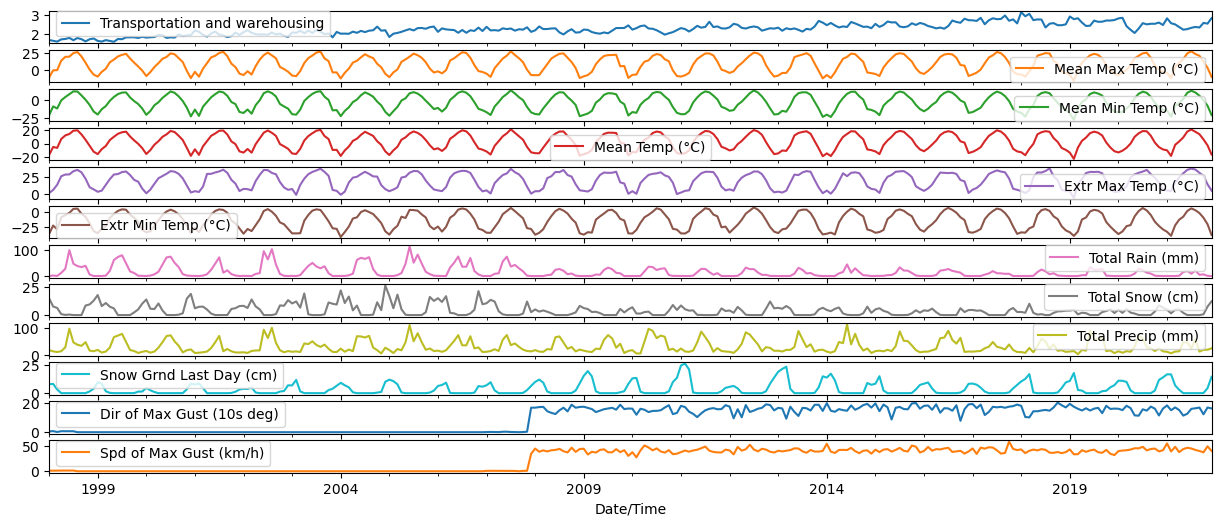

In [320]:
resampled[[
    'Transportation and warehousing',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)']].plot(subplots = True)

In [321]:
# split into train and test
train_end_date = '2018-12-31'

train_data = resampled[resampled.index <= train_end_date]
test_data = resampled[resampled.index > train_end_date]

print(f'Train data:')
print(train_data.index.min())
print(train_data.index.max())
print(train_data.shape)
print(f'Test data:')
print(test_data.index.min())
print(test_data.index.max())
print(test_data.shape)

Train data:
1998-01-31 00:00:00
2018-12-31 00:00:00
(252, 12)
Test data:
2019-01-31 00:00:00
2021-12-31 00:00:00
(36, 12)


In [322]:
train_data_array = train_data.values
print(train_data_array[0])
print(train_data_array.shape)

test_data_array = test_data.values
print(test_data_array[0])
print(test_data_array.shape)


[  1.6623016 -12.1266961 -21.6433711 -16.9118767   1.9577753 -36.1323565
   0.0711111  15.2022222  17.2711111   7.9777778   0.5111111   1.2444444]
(252, 12)
[  2.9208915  -7.9429451 -18.9879809 -13.4659745   4.2788504 -33.2154414
   0.072       4.064      11.956      10.86       19.28       43.78     ]
(36, 12)


In [323]:
def split_to_train_test(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i - n_past,0])
    return np.array(dataX),np.array(dataY)    

In [324]:
time_steps = 1

# TRAIN
X_train, y_train = split_to_train_test(train_data_array, time_steps)
print('Before reshape:')
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train = X_train.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_train:', X_train.shape)

y_train = y_train.reshape((-1, 1))
print('y_train:', y_train.shape)

# TEST
X_test, y_test = split_to_train_test(test_data_array, time_steps)
print('Before reshape:')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_test = X_test.reshape(-1, X_train.shape[-1])
print('After reshape:')
print('X_test:', X_test.shape)

y_test = y_test.reshape((-1, 1))
print('y_test:', y_test.shape)

Before reshape:
X_train: (251, 1, 11)
y_train: (251,)
After reshape:
X_train: (251, 11)
y_train: (251, 1)
Before reshape:
X_test: (35, 1, 11)
y_test: (35,)
After reshape:
X_test: (35, 11)
y_test: (35, 1)


In [325]:
scaler_1 = StandardScaler()
np.set_printoptions(precision=7)
X_train_scaled = scaler_1.fit_transform(X_train)
print('X_train_scaled:', X_train_scaled[0])
print('X_train_scaled:', X_train_scaled.shape)

scaler_2 = StandardScaler()
y_train_scaled = scaler_2.fit_transform(y_train)
print('y_train_scaled:', y_train_scaled[0:5])
print('y_train_scaled:', y_train_scaled.shape)

scaler_3 = StandardScaler()
X_test_scaled = scaler_3.fit_transform(X_test)
print('X_test_scaled:', X_test_scaled[0])
print('X_test_scaled:', X_test_scaled.shape)

scaler_4 = StandardScaler()
y_test_scaled = scaler_4.fit_transform(y_test)
print('y_test_scaled:', y_test_scaled[0:5])
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: [-1.6812887 -1.6721318 -1.680284  -1.581688  -1.5688754 -0.7396374
  2.1224493 -0.5814022  0.8620398 -0.9689718 -0.9868197]
X_train_scaled: (251, 11)
y_train_scaled: [[-1.8262786]
 [-1.9612804]
 [-2.1085035]
 [-1.7039601]
 [-1.6365286]]
y_train_scaled: (251, 1)
X_test_scaled: [-1.3483729 -1.3886487 -1.3692025 -1.4155954 -1.3105086 -0.7790129
  0.6245494 -0.6676608  1.1073046  1.878988   0.3130679]
X_test_scaled: (35, 11)
y_test_scaled: [[ 1.8540127]
 [ 1.1700022]
 [ 1.399412 ]
 [ 0.2936232]
 [-0.5825273]]
y_test_scaled: (35, 1)


In [326]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (251, 11)
X_test: (35, 11)


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 1, 128)            71680     
                                                                 
 dropout_27 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_52 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 203393 (794.50 KB)
Trainable params: 203393 (794.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train Mean Sq

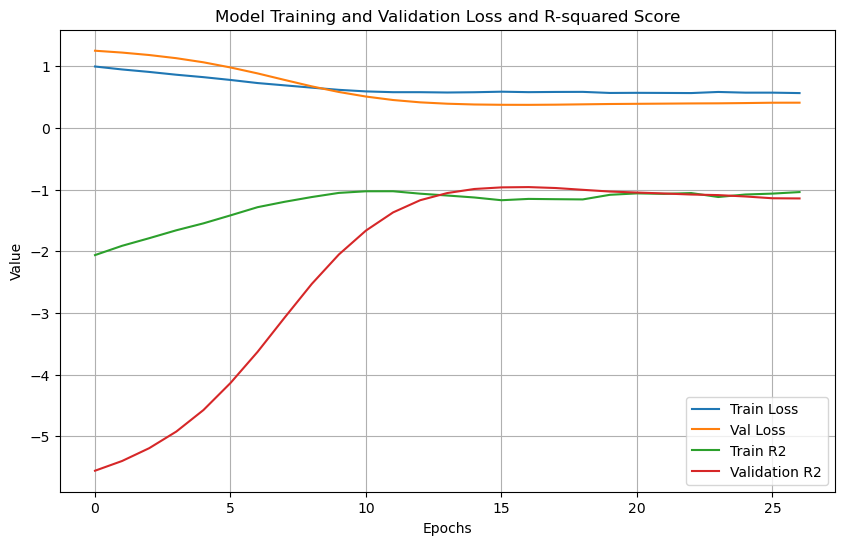

In [327]:
from keras.optimizers import Adam

# initialize model
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='mse',
              metrics=[r_squared])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# fit model
history = model.fit(X_train_scaled, y_train_scaled,
          epochs = 100,
          batch_size = 64,
          verbose = 0,
          callbacks=[early_stopping],
          shuffle = False,
          validation_split = 0.02)

# Obtain the MSE and R-squared from the last epoch
last_epoch_mse = history.history['loss'][-1]
last_epoch_r_squared = history.history['r_squared'][-1]
last_epoch_mse_val = history.history['val_loss'][-1]
last_epoch_r_squared_val = history.history['val_r_squared'][-1]

# Print the MSE and R-squared
print("Train Mean Squared Error (MSE) from the last epoch:", last_epoch_mse)
print("Train R-squared from the last epoch:", last_epoch_r_squared)
print("Val Mean Squared Error (MSE) from the last epoch:", last_epoch_mse_val)
print("Val R-squared from the last epoch:", last_epoch_r_squared_val)

# plot loss and r2 score
plt.figure(figsize=(10, 6))

# Plot train loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Plot train R-squared score
plt.plot(history.history['r_squared'], label='Train R2')
plt.plot(history.history['val_r_squared'], label='Validation R2')

plt.title('Model Training and Validation Loss and R-squared Score')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [328]:
# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print("MSE and R_squared:", loss)

2/2 [==============================] - 0s 8ms/step - loss: 1.0425 - r_squared: -1.0002
MSE and R_squared: [1.0424656867980957, -1.0002071857452393]


In [329]:
train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
print('train_predict:', train_predict.shape)
print('test_predict:', test_predict.shape)

2/2 [==============================] - 0s 8ms/step
train_predict: (251, 1)
test_predict: (35, 1)


In [330]:
# invert predictions
train_predict = scaler_2.inverse_transform(train_predict)
print('train_predict:', train_predict.shape)

# invert y_train
y_train_scaled_inversed = scaler_2.inverse_transform(y_train_scaled)
print('y_train_scaled_inversed:', y_train_scaled_inversed.shape)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_train)), y=y_train.flatten(), mode='lines', name='Actual Train')
trace2 = go.Scatter(x=np.arange(len(train_predict)), y=train_predict.flatten(), mode='lines', name='Predicted Train')

# Create layout
layout = go.Layout(
    title='Saskatchewan: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

train_predict: (251, 1)
y_train_scaled_inversed: (251, 1)
Train Mean Absolute Error: 0.17863105647148095
Train Root Mean Squared Error: 0.2219552450481142


In [331]:
# invert predictions
test_predict = scaler_4.inverse_transform(test_predict)
print('test_predict:', test_predict.shape)

# invert y_test
y_test_scaled_inversed = scaler_4.inverse_transform(y_test_scaled)
print('y_test_scaled_inversed:', y_test_scaled_inversed.shape)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

# plot the actual and predicted values for test data
trace1 = go.Scatter(x=np.arange(len(y_test)), y=y_test.flatten(), mode='lines', name='Actual Test')
trace2 = go.Scatter(x=np.arange(len(test_predict)), y=test_predict.flatten(), mode='lines', name='Predicted Test')

# Create layout
layout = go.Layout(
    title='Saskatchewan: LSTM Prediction on Transportation and warehousing',
    xaxis=dict(title='Time step'),
    yaxis=dict(title='Transportation and warehousing'),
    legend=dict(x=0, y=1.18)
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

test_predict: (35, 1)
y_test_scaled_inversed: (35, 1)
Test Mean Absolute Error: 0.18254650785110715
Test Root Mean Squared Error: 0.21269623448709327
